In [51]:
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim
import tqdm.notebook as tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToPILImage
from IPython.display import Image
from scipy.stats import pearsonr

import copy
import os
import sys
sys.path.append('/Users/Matt/projects/gmmvae/')

import gmmvae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preparation.

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST('../data', train=True, download=True,
                               transform=transform)
test_dataset = datasets.MNIST('../data', train=False,
                              transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Classifier training.

In [3]:
def train_cls(model, train_loader, optimiser, epoch):
    model.train()
    batch_iter = tqdm.tqdm(enumerate(train_loader), desc='Batch')
    for batch_idx, (x, y) in batch_iter:
        optimiser.zero_grad()
        loss, _ = model.nll(x, y)
        loss.backward()
        optimiser.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test_cls(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            loss, output = model.nll(x, y)
            test_loss += loss.item()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [4]:
cls = gmmvae.classifiers.MNISTClassificationNet()
cls_optimiser = optim.Adadelta(cls.parameters(), lr=1.0)
cls_scheduler = StepLR(cls_optimiser, step_size=1, gamma=0.7)

In [5]:
for epoch in range(1, 14+1):
    train_cls(cls, train_loader, cls_optimiser, epoch)
    test_cls(cls, test_loader)
    cls_scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311675
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.819473
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.059483
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.818036
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.580314
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.498336
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.414408
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.214482
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.635520
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.200644
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.357830
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.309428
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.457570
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.371049
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.234372
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.126006
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.293846
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.253333
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.138134
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.282809
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.031406
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.217215
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.047661
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.031029
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.037686
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.057878
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.047265
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.072018
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.346007
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.042864
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.030003
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.025194
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.166564
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.068333
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.052595
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.050757
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.051107
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.098029
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.013519
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.165722
Train Epoch: 2 [12800/60000 (

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.026977
Train Epoch: 3 [640/60000 (1%)]	Loss: 0.025635
Train Epoch: 3 [1280/60000 (2%)]	Loss: 0.093120
Train Epoch: 3 [1920/60000 (3%)]	Loss: 0.019142
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.162088
Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.075949
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.254335
Train Epoch: 3 [4480/60000 (7%)]	Loss: 0.060049
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.074609
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.046854
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.013330
Train Epoch: 3 [7040/60000 (12%)]	Loss: 0.016965
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.014727
Train Epoch: 3 [8320/60000 (14%)]	Loss: 0.012136
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.027309
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.025386
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.027887
Train Epoch: 3 [10880/60000 (18%)]	Loss: 0.020251
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.015470
Train Epoch: 3 [12160/60000 (20%)]	Loss: 0.147176
Train Epoch: 3 [12800/60000 (

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.008440
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.013944
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.026668
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.100068
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.015069
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.031095
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.004085
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.002862
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.101702
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.007218
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.079184
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.078072
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.024320
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.030783
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.007692
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.012855
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.004669
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.021478
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.020749
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.083670
Train Epoch: 4 [12800/60000 (

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.045093
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.010605
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.071603
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.141087
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.010573
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.021426
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.015141
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.031572
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.062513
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.029543
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.010522
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.009154
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.030605
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.054920
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.010302
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.009395
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.004822
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.052194
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.009341
Train Epoch: 5 [12160/60000 (20%)]	Loss: 0.109081
Train Epoch: 5 [12800/60000 (

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.003006
Train Epoch: 6 [640/60000 (1%)]	Loss: 0.005132
Train Epoch: 6 [1280/60000 (2%)]	Loss: 0.000454
Train Epoch: 6 [1920/60000 (3%)]	Loss: 0.001533
Train Epoch: 6 [2560/60000 (4%)]	Loss: 0.026129
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.004532
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.003820
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.021196
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.000828
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.015365
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.048034
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.022196
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.026957
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.011595
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.050647
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.009363
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.233294
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.012969
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.016120
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.002294
Train Epoch: 6 [12800/60000 (

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.030592
Train Epoch: 7 [640/60000 (1%)]	Loss: 0.028213
Train Epoch: 7 [1280/60000 (2%)]	Loss: 0.015111
Train Epoch: 7 [1920/60000 (3%)]	Loss: 0.002352
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.005841
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.005667
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.009284
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.048002
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.008670
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.030162
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.098791
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.094683
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.146236
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.181855
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.021594
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.011157
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.021178
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.007759
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.015259
Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.013545
Train Epoch: 7 [12800/60000 (

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.128057
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.016721
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.014693
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.063595
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.002387
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.005524
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.033438
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.156059
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.156798
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.007105
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.012106
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.010148
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.047753
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.033023
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.048536
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.016381
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.013678
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.011597
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.044671
Train Epoch: 8 [12160/60000 (20%)]	Loss: 0.006585
Train Epoch: 8 [12800/60000 (

KeyboardInterrupt: 

## Set GMMVAE datasets. 

In [6]:
pred_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
cls_output = torch.zeros(len(train_dataset), 10)
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(pred_loader):
        cls_output[batch_idx*64:(batch_idx+1)*64] = cls(x).detach().exp()

In [7]:
class GMMVAEDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, cls_output):
        self.x = x
        self.y = y
        self.cls_output = cls_output
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.x[idx, ...], self.cls_output[idx]
    
gmmvae_dataset = GMMVAEDataset(train_dataset.data, train_dataset.targets, cls_output)
gmmvae_loader = torch.utils.data.DataLoader(gmmvae_dataset, batch_size=64)

In [8]:
def train_gmmvae(model, loader, optimiser, epoch):
    model.train()
    train_loss = 0
    batch_iter = tqdm.tqdm(enumerate(loader), desc='Batch')
    
    for batch_idx, (x, pi) in batch_iter:
        optimiser.zero_grad() 
        if isinstance(model, gmmvae.models.GMMVAEFixedCls):
            x = x.unsqueeze(1).float() / 255
            loss = -model.elbo(x, pi, num_samples=1)
        elif type(model) in [gmmvae.models.WeightedVAE, gmmvae.models.HierarchicalVAE, 
                             gmmvae.models.MultiModalVAE, gmmvae.models.GMMVAE]:
            x = x.view(-1, 784).float() / 255
            loss = -model.elbo(x, pi, num_samples=1)
        elif type(model) in [gmmvae.models.EntroVAE]:
            x = x.view(-1, 784).float() / 255
            h = (- pi * (pi.log() / np.log(2))).sum(1)
            loss = -model.elbo(x, h, num_samples=1)
        else:
            x = x.view(-1, 784).float() / 255
            loss = -model.elbo(x, num_samples=1)
        
        loss.backward()
        
        optimiser.step()
        
        train_loss += loss.item()        
        batch_iter.set_postfix(loss=loss.item())
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(loader.dataset)))

In [10]:
z_dim = 2
x_dim = 784

variational_dist_x = gmmvae.likelihoods.NNHeteroGaussian(x_dim, z_dim, [512, 256], min_sigma=1e-3)
likelihood_z = gmmvae.likelihoods.NNHeteroGaussian(10, z_dim, [10, 10], min_sigma=1e-3)
variational_dist_xy = gmmvae.likelihoods.NNHeteroGaussianIndexed(x_dim, z_dim, 10, [512, 256], min_sigma=1e-3)
likelihood_x = gmmvae.likelihoods.NNBernoulli(z_dim, x_dim, [256, 512])
likelihood_y = gmmvae.likelihoods.NNCategorical(z_dim, 10, [10, 10])
variational_dist_y = gmmvae.likelihoods.NNHeteroGaussian(10, z_dim, [10, 10], min_sigma=1e-3)

gmmvae_cls = copy.deepcopy(cls)
for param in gmmvae_cls.parameters():
    param.requires_grad = False

# Define various VAE models.
vae = gmmvae.models.VAE(
    copy.deepcopy(likelihood_x), copy.deepcopy(variational_dist_x), z_dim)

entrovae = gmmvae.models.EntroVAE(
    copy.deepcopy(likelihood_x), copy.deepcopy(variational_dist_x), z_dim)

wvae = gmmvae.models.WeightedVAE(
    copy.deepcopy(likelihood_x), copy.deepcopy(variational_dist_x), z_dim, 10)

gmmvae_model = gmmvae.models.GMMVAE(
    copy.deepcopy(likelihood_x), copy.deepcopy(variational_dist_x), z_dim, 10)

gmmvaecls = gmmvae.models.GMMVAEFixedCls(
    copy.deepcopy(likelihood_x), gmmvae_cls, variational_dist_xy,  z_dim, 10)

hvae = gmmvae.models.HierarchicalVAE(
    copy.deepcopy(likelihood_x), copy.deepcopy(likelihood_z), copy.deepcopy(variational_dist_x), z_dim)

mmvae = gmmvae.models.MultiModalVAE(
    copy.deepcopy(likelihood_x), copy.deepcopy(likelihood_y), copy.deepcopy(variational_dist_x), 
    copy.deepcopy(variational_dist_y), z_dim)

## GMMVAE training.

In [11]:
vae_optimiser = optim.Adam(vae.parameters())
for epoch in range(1, 14+1):
    train_gmmvae(vae, gmmvae_loader, vae_optimiser, epoch)


====> Epoch: 1 Average loss: 2.8193



====> Epoch: 2 Average loss: 2.5172



====> Epoch: 3 Average loss: 2.4272



====> Epoch: 4 Average loss: 2.3773



====> Epoch: 5 Average loss: 2.3413



====> Epoch: 6 Average loss: 2.3147



====> Epoch: 7 Average loss: 2.2939



====> Epoch: 8 Average loss: 2.2788



====> Epoch: 9 Average loss: 2.2649



====> Epoch: 10 Average loss: 2.2548



====> Epoch: 11 Average loss: 2.2448



====> Epoch: 12 Average loss: 2.2366



====> Epoch: 13 Average loss: 2.2308



====> Epoch: 14 Average loss: 2.2231


In [12]:
entrovae_optimiser = optim.Adam(entrovae.parameters())
for epoch in range(1, 14+1):
    train_gmmvae(entrovae, gmmvae_loader, entrovae_optimiser, epoch)


====> Epoch: 1 Average loss: 3.0399



====> Epoch: 2 Average loss: 2.7481



====> Epoch: 3 Average loss: 2.6598



====> Epoch: 4 Average loss: 2.6082



====> Epoch: 5 Average loss: 2.5737



====> Epoch: 6 Average loss: 2.5478



====> Epoch: 7 Average loss: 2.5290



====> Epoch: 8 Average loss: 2.5127



====> Epoch: 9 Average loss: 2.4998



====> Epoch: 10 Average loss: 2.4890



====> Epoch: 11 Average loss: 2.4824



====> Epoch: 12 Average loss: 2.4766



====> Epoch: 13 Average loss: 2.4676



====> Epoch: 14 Average loss: 2.4598


In [13]:
wvae_optimiser = optim.Adam(wvae.parameters())
for epoch in range(1, 14+1):
    train_gmmvae(wvae, gmmvae_loader, wvae_optimiser, epoch)


====> Epoch: 1 Average loss: 2.7966



====> Epoch: 2 Average loss: 2.5053



====> Epoch: 3 Average loss: 2.4181



====> Epoch: 4 Average loss: 2.3612



====> Epoch: 5 Average loss: 2.3175



====> Epoch: 6 Average loss: 2.2885



====> Epoch: 7 Average loss: 2.2638



====> Epoch: 8 Average loss: 2.2444



====> Epoch: 9 Average loss: 2.2273



====> Epoch: 10 Average loss: 2.2158



====> Epoch: 11 Average loss: 2.2048



====> Epoch: 12 Average loss: 2.1981



====> Epoch: 13 Average loss: 2.1901



====> Epoch: 14 Average loss: 2.1860


In [14]:
gmmvae_optimiser = optim.Adam(gmmvae_model.parameters())
for epoch in range(1, 14+1):
    train_gmmvae(gmmvae_model, gmmvae_loader, gmmvae_optimiser, epoch)


====> Epoch: 1 Average loss: 2.7935



====> Epoch: 2 Average loss: 2.4889



====> Epoch: 3 Average loss: 2.3908



====> Epoch: 4 Average loss: 2.3311



====> Epoch: 5 Average loss: 2.2987



====> Epoch: 6 Average loss: 2.2686



====> Epoch: 7 Average loss: 2.2477



====> Epoch: 8 Average loss: 2.2310



====> Epoch: 9 Average loss: 2.2209



====> Epoch: 10 Average loss: 2.2085



====> Epoch: 11 Average loss: 2.2045



====> Epoch: 12 Average loss: 2.1930



====> Epoch: 13 Average loss: 2.1856



====> Epoch: 14 Average loss: 2.1799


In [15]:
gmmvaecls_optimiser = optim.Adam(gmmvaecls.parameters())
for epoch in range(1, 14+1):
    train_gmmvae(gmmvaecls, gmmvae_loader, gmmvaecls_optimiser, epoch)

KeyboardInterrupt: 

In [16]:
hvae_optimiser = optim.Adam(hvae.parameters())
for epoch in range(1, 14+1):
    train_gmmvae(hvae, gmmvae_loader, hvae_optimiser, epoch)


====> Epoch: 1 Average loss: 2.8737



====> Epoch: 2 Average loss: 2.4992



====> Epoch: 3 Average loss: 2.3865



====> Epoch: 4 Average loss: 2.3279



====> Epoch: 5 Average loss: 2.2888



====> Epoch: 6 Average loss: 2.2586



====> Epoch: 7 Average loss: 2.2370



====> Epoch: 8 Average loss: 2.2203



====> Epoch: 9 Average loss: 2.2104



====> Epoch: 10 Average loss: 2.1970



====> Epoch: 11 Average loss: 2.1886



====> Epoch: 12 Average loss: 2.1800



====> Epoch: 13 Average loss: 2.1732



====> Epoch: 14 Average loss: 2.1656


In [17]:
mmvae_optimiser = optim.Adam(mmvae.parameters())
for epoch in range(1, 14+1):
    train_gmmvae(mmvae, gmmvae_loader, mmvae_optimiser, epoch)


====> Epoch: 1 Average loss: 2.8878



====> Epoch: 2 Average loss: 2.5614



====> Epoch: 3 Average loss: 2.4819



====> Epoch: 4 Average loss: 2.4226



====> Epoch: 5 Average loss: 2.3821



====> Epoch: 6 Average loss: 2.3530



====> Epoch: 7 Average loss: 2.3288



====> Epoch: 8 Average loss: 2.3065



====> Epoch: 9 Average loss: 2.2991



====> Epoch: 10 Average loss: 2.2849



====> Epoch: 11 Average loss: 2.2695



====> Epoch: 12 Average loss: 2.2659



====> Epoch: 13 Average loss: 2.2562



====> Epoch: 14 Average loss: 2.2479


## Sample model.

In [20]:
if not os.path.exists('./samples'):
    os.makedirs('./samples')

with torch.no_grad():            
    sample = gmmvae_model.sample(num_samples=100)
    
    filename = './samples/gmmvae_sample'
    
    if os.path.exists(filename + '.png'):
        i = 1
        while os.path.exists(filename + '_' + str(i) + '.png'):
            i += 1
            
        filename = filename + '_' + str(i) + '.png'
        
    else:
        filename = filename + '.png'
    
    save_image(sample.view(100, 1, 28, 28), filename)

## Visualise clustering of latent space.

In [63]:
from matplotlib.patches import Ellipse, Rectangle

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes.
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def distance_from_mean(z, y, mus=None):
    sd = torch.zeros(len(z))
    for k in range(y.max()):
        zk = z[y == k, :]
        
        if mus is None:
            muk = zk.mean(0)
        else:
            muk = mus[k]
            
        sdk = ((zk - muk) ** 2).sum(1)
        sd[y == k] = sdk
        
    return sd

def entropy_sd_corrcoef(z, h, y, mus=None):
    sd = distance_from_mean(z, y, mus)
    
    # Pearson correlation coefficient requires each dataset to be normally distributed.
    h_mu, h_std = h.mean(), h.std()
    sd_mu, sd_std = sd.mean(), sd.std()
    h = (h - h_mu) / h_std
    sd = (sd - sd_mu) / sd_std
    
    return pearsonr(h, sd)
        
def plot_gmmvae(model, x, y, pi, ax=None):
    ax = ax or plt.gca()
    qz = model.variational_dist(x)
    z = qz.sample()
    h = - (pi * (pi.log()) / np.log(2)).sum(1)
    
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    c = [colours[y_] for y_ in y]
    s = 50 * h / h.max()
#     s = 20
    ax.scatter(z[:, 0], z[:, 1], c=c, alpha=.75, marker='x', s=s)
    ax.axis('equal')
    
    mus = []
    for mu in model.pz_y_mu:
        mus.append(mu.detach().numpy())
        
    coeff = entropy_sd_corrcoef(z, h, y, mus)
    print(coeff)
    
#     for mu, logsigma, colour in zip(gmmvae.pz_y_mu, gmmvae.pz_y_logsigma, colours):
#         mu = mu.detach().numpy()
#         cov = logsigma.exp().diag_embed().detach().numpy()
#         draw_ellipse(mu, cov, alpha=.1, color=colour)
        

def plot_vae(model, x, y, pi, ax=None):
    ax = ax or plt.gca()
    qz = model.variational_dist(x)
    z = qz.sample()
    h = - (pi * (pi.log()) / np.log(2)).sum(1)
    
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    c = [colours[y_] for y_ in y]
    s = 50 * h / h.max()
#     s = 20
    ax.scatter(z[:, 0], z[:, 1], c=c, alpha=.75, marker='x', s=s)
    ax.axis('equal')
    
    coeff = entropy_sd_corrcoef(z, h, y)
    print(coeff)
    
def plot_mmvae(model, x, y, pi, ax=None):
    ax = ax or plt.gca()
    qz = model.qz(x, pi)
    z = qz.sample()
    h = - (pi * (pi.log()) / np.log(2)).sum(1)
    
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    c = [colours[y_] for y_ in y]
#     s = 20
    s = 20 * h / h.max()
    ax.scatter(z[:, 0], z[:, 1], c=c, alpha=.75, marker='x', s=s)
    ax.axis('equal')
    
    coeff = entropy_sd_corrcoef(z, h, y)
    print(coeff)

(0.0568628836150223, 0.07227727141665673)


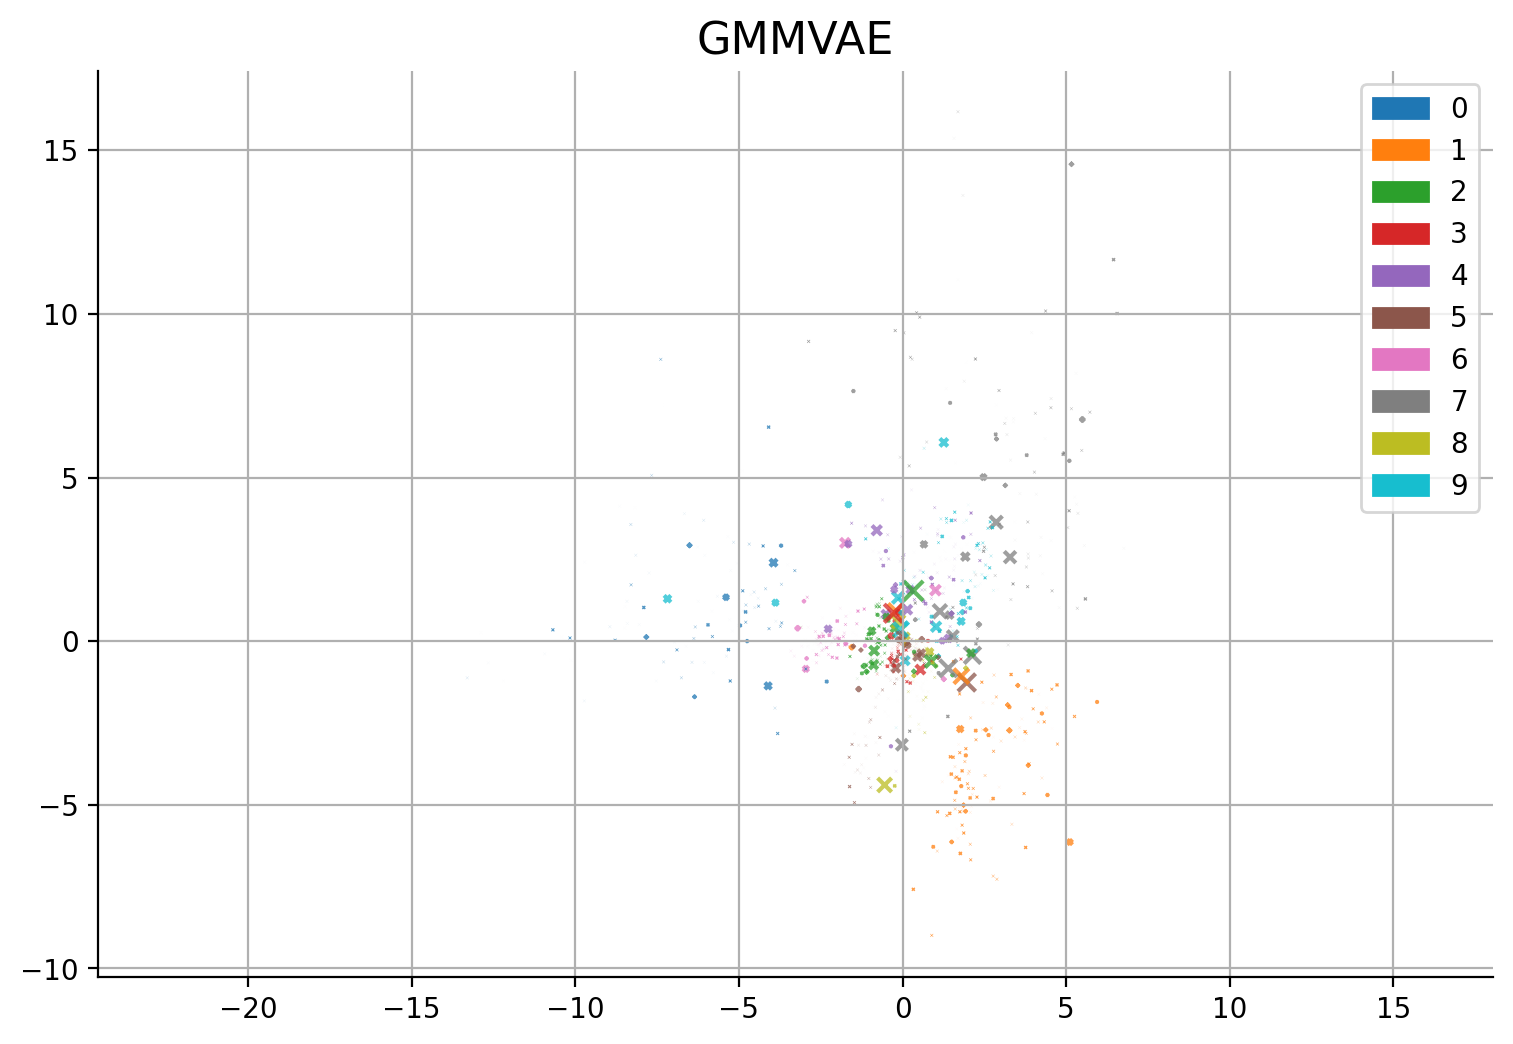

In [64]:
fig = plt.figure(figsize=(9, 6), dpi=200)

x = gmmvae_dataset.x[:1000].view(-1, 784).float() / 255
y = gmmvae_dataset.y[:1000]
pi = gmmvae_dataset.cls_output[:1000]
plot_gmmvae(gmmvae_model, x, y, pi)

# Hide the right and top spines.
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add legend.
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_patches = [Rectangle((0, 0), 1, 1, color=colours[i]) for i in range(10)]
ax.legend(custom_patches, [str(i) for i in range(10)])

plt.title('GMMVAE', fontsize=16)
plt.grid(0.25)
plt.show()

(0.1972013405624424, 3.172183348474778e-10)


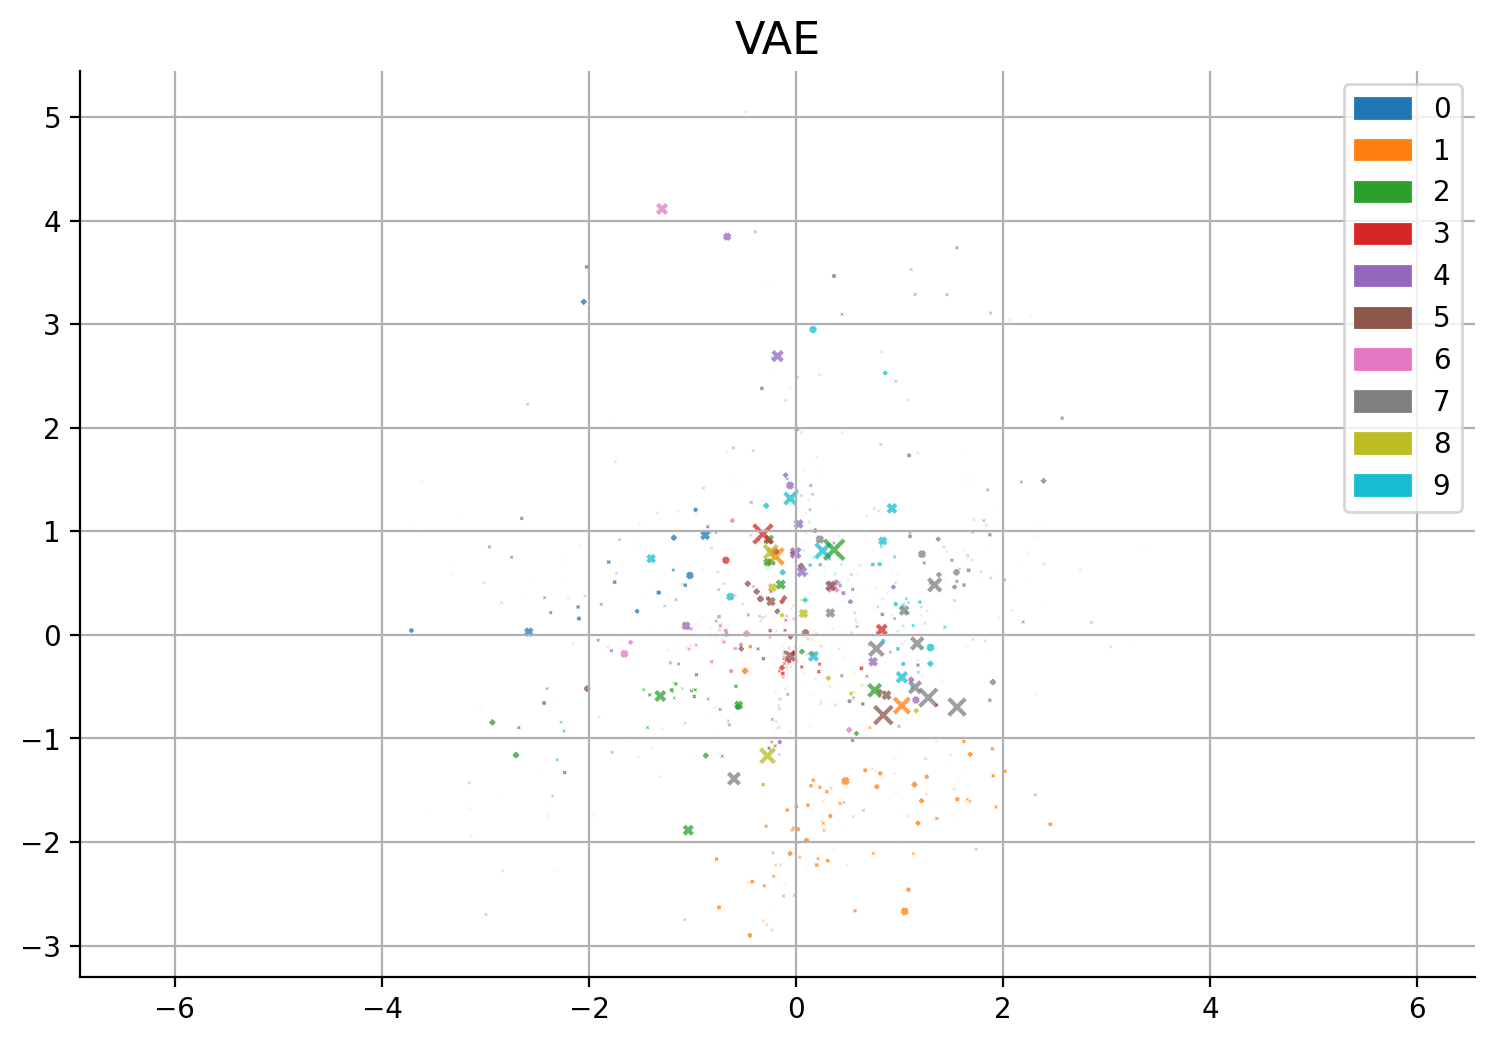

In [65]:
fig = plt.figure(figsize=(9, 6), dpi=200)

x = gmmvae_dataset.x[:1000].view(-1, 784).float() / 255
y = gmmvae_dataset.y[:1000]
pi = gmmvae_dataset.cls_output[:1000]
plot_vae(vae, x, y, pi)

# Hide the right and top spines.
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add legend.
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_patches = [Rectangle((0, 0), 1, 1, color=colours[i]) for i in range(10)]
ax.legend(custom_patches, [str(i) for i in range(10)])

plt.title('VAE', fontsize=16)
plt.grid(0.25)
plt.show()

(0.05074644489457238, 0.10876480883704594)


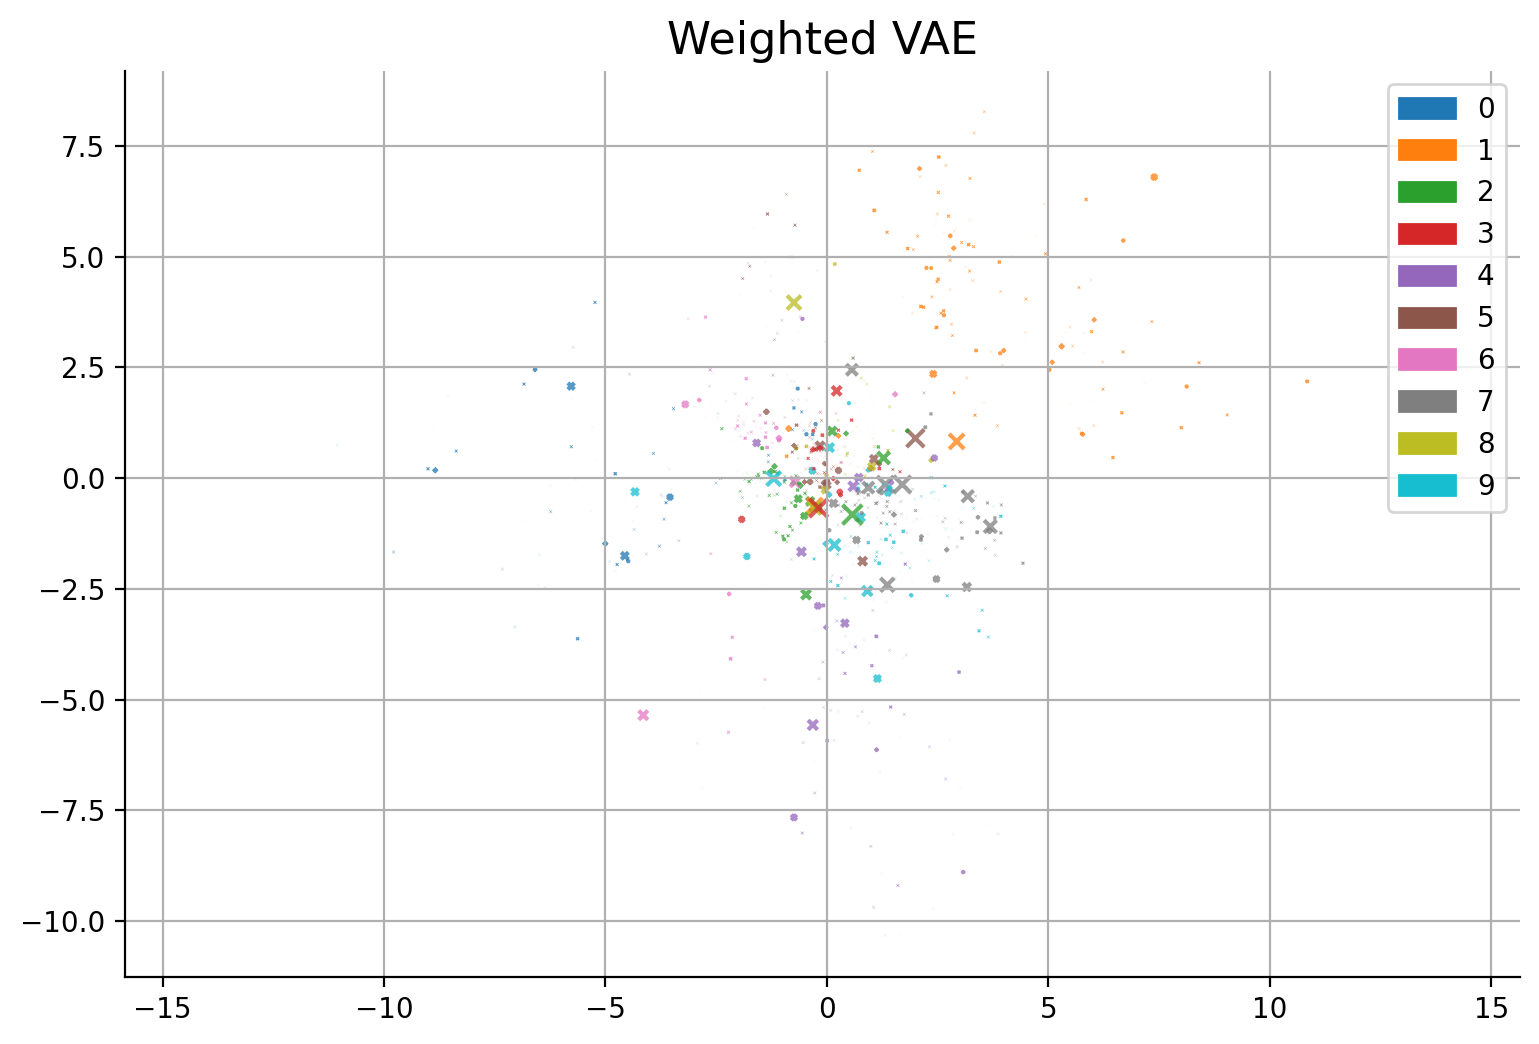

In [66]:
fig = plt.figure(figsize=(9, 6), dpi=200)

x = gmmvae_dataset.x[:1000].view(-1, 784).float() / 255
y = gmmvae_dataset.y[:1000]
pi = gmmvae_dataset.cls_output[:1000]
plot_vae(wvae, x, y, pi)

# Hide the right and top spines.
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add legend.
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_patches = [Rectangle((0, 0), 1, 1, color=colours[i]) for i in range(10)]
ax.legend(custom_patches, [str(i) for i in range(10)])

plt.grid(0.25)
plt.title('Weighted VAE', fontsize=16)
# plt.savefig('../figures/mnist/weighted_vae_latent_space.png', dpi=400, bbox_inches='tight')
plt.show()

(0.08225602483477125, 0.00925949979513968)


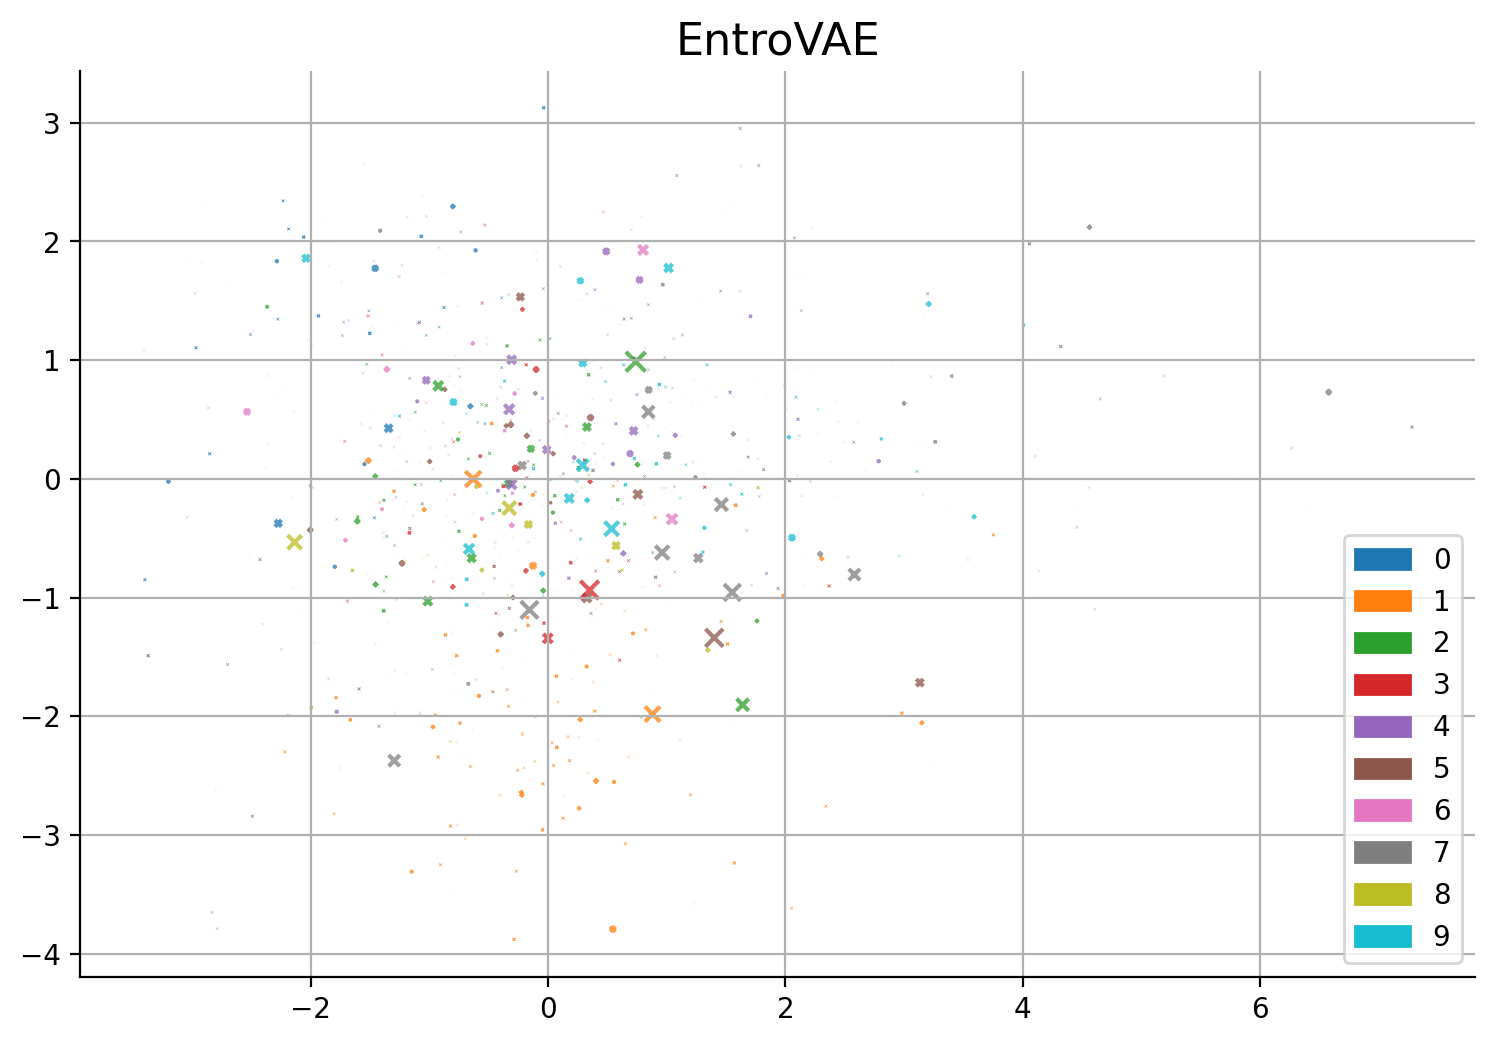

In [67]:
fig = plt.figure(figsize=(9, 6), dpi=200)

x = gmmvae_dataset.x[:1000].view(-1, 784).float() / 255
y = gmmvae_dataset.y[:1000]
pi = gmmvae_dataset.cls_output[:1000]
plot_vae(entrovae, x, y, pi)

# Hide the right and top spines.
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add legend.
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_patches = [Rectangle((0, 0), 1, 1, color=colours[i]) for i in range(10)]
ax.legend(custom_patches, [str(i) for i in range(10)])

plt.grid(0.25)
plt.title('EntroVAE', fontsize=16)
# plt.savefig('../figures/mnist/vae_latent_space.png', dpi=400, bbox_inches='tight')
plt.show()

(0.07125319962990835, 0.024242109792631635)


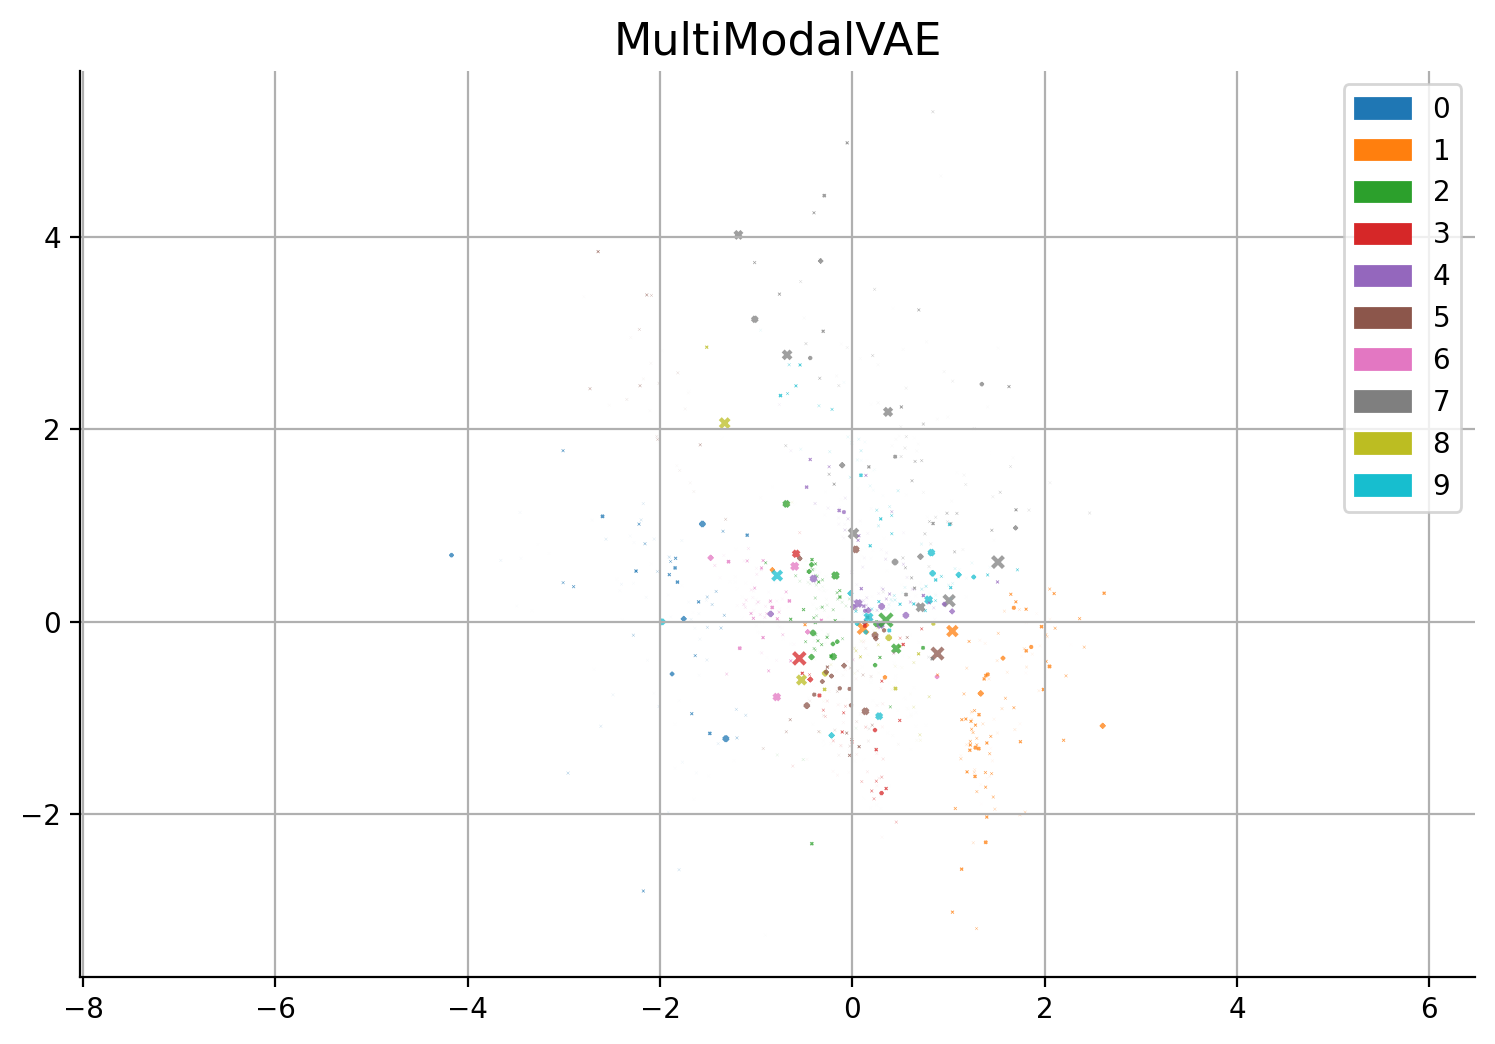

In [68]:
fig = plt.figure(figsize=(9, 6), dpi=200)

x = gmmvae_dataset.x[:1000].view(-1, 784).float() / 255
y = gmmvae_dataset.y[:1000]
pi = gmmvae_dataset.cls_output[:1000]
plot_mmvae(mmvae, x, y, pi)

# Hide the right and top spines.
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add legend.
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_patches = [Rectangle((0, 0), 1, 1, color=colours[i]) for i in range(10)]
ax.legend(custom_patches, [str(i) for i in range(10)])

plt.grid(0.25)
plt.title('MultiModalVAE', fontsize=16)
# plt.savefig('../figures/mnist/hierarchical_vae_latent_space.png', dpi=400, bbox_inches='tight')
plt.show()

(0.09178627754815025, 0.0036720517748967856)


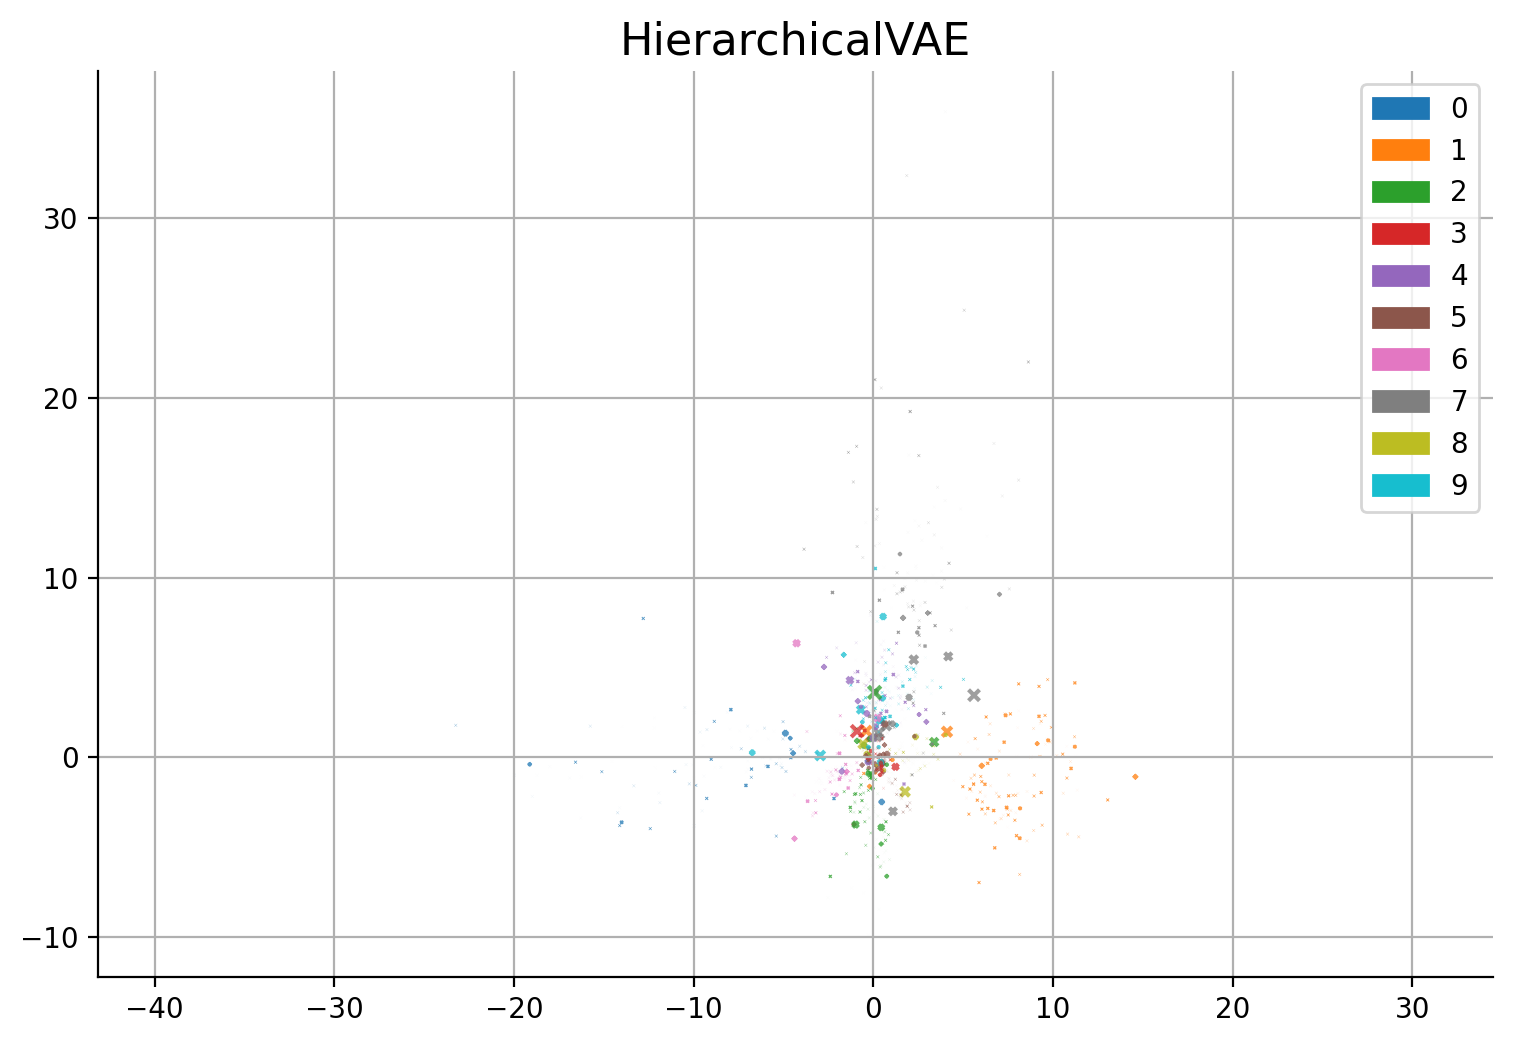

In [69]:
fig = plt.figure(figsize=(9, 6), dpi=200)

x = gmmvae_dataset.x[:1000].view(-1, 784).float() / 255
y = gmmvae_dataset.y[:1000]
pi = gmmvae_dataset.cls_output[:1000]
plot_mmvae(hvae, x, y, pi)

# Hide the right and top spines.
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add legend.
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_patches = [Rectangle((0, 0), 1, 1, color=colours[i]) for i in range(10)]
ax.legend(custom_patches, [str(i) for i in range(10)])

plt.grid(0.25)
plt.title('HierarchicalVAE', fontsize=16)
# plt.savefig('../figures/mnist/hierarchical_vae_latent_space.png', dpi=400, bbox_inches='tight')
plt.show()

## Inspect individual samples

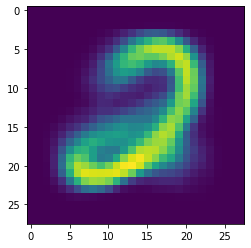

In [120]:
pi = torch.zeros(10)
pi[5] = 1

x_sample, px = gmmvae_model.sample(pi=pi)
img = px.mean.detach().reshape(-1, 28, 28).numpy()

plt.imshow(np.transpose(img, (1,2,0)))

In [40]:
img.shape

(1, 784)

In [33]:
pi

tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])